# Sanjay Avva - Project II Part II

## Date: 11/11/25
### Scraping + Cleaning + Graphing Viz(es) to answer questions


### Importing Scraping Libs (requests, bs4), Cleaning Libs (pandas, os), Computing Libs (string, numpy, regex, counter, defaultdict) and Seaborn/MatplotLib for graphing

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import string
import numpy as np

### Getting HTML source using bs4 and requests:

In [2]:
soup = "" #soup creation
i=46 #Setting looping index for page collection (Scraping page columns from page 46 to page 51)
url = "https://stackoverflow.com/questions?tab=unanswered&page="+(str(i))
resp = requests.get(url)
status = resp.status_code
if status == 200:
    page = resp.text #init parser and extract html content
    soup = bs(page, features="html.parser")
else:
    print(f"Bad | Received status code {status}")

###Creating common func for parsing through soup to scrape data into CSVs:

In [3]:
def getTable(soup,interval_title=i): # general function for mentioned 46-51 page indexing
    i_title = interval_title+1
    postcontents = [] #buckets for scraping (extracting post preview content, tags, user rep, views)
    tagsets = []
    user_repsets = []
    viewagesets= []
    for div in soup.find_all('div', attrs={'id': 'questions'}): #page content is in innerhtml of nested divs with specific ids and classes
        for item1 in div.find_all('div', attrs={'class': 's-post-summary js-post-summary'}):
            for item2 in item1.find_all('div', attrs={'class': 's-post-summary--content-excerpt'}):
                postcontents.append(item2.text) #place into bucket

        for item3 in div.find_all('div', attrs={'class': 's-post-summary js-post-summary'}):#page content is in column innerhtml of nested divs with specific ids and classes
            for item4 in item3.find_all('div', attrs={'class': 's-post-summary--meta'}):
                for item5 in item4.find_all('div', attrs={'class': 's-post-summary--meta-tags'}):
                    for item6 in item5.find_all('ul', attrs={'class': 'js-post-tag-list-wrapper'}):
                        tempULgroup = [] #individiual tag collection of ea. post
                        for item7 in item6.find_all('li', attrs={'class': 'js-post-tag-list-item'}):
                            for item8 in item7.find_all('a', attrs={'class': 'post-tag'}):
                                tempULgroup.append(item8.text)
                        tagsets.append(tempULgroup) #sending tag grouping per post to bucket

        for item9 in div.find_all('div', attrs={'class': 's-post-summary js-post-summary'}):#page content is in innerhtml of nested divs with specific ids and classes
            for item10 in item9.find_all('div', attrs={'class': 's-post-summary--meta'}):
                for item11 in item10.find_all('div', attrs={'class': 's-user-card s-user-card__minimal'}):
                    for item12 in item11.find_all('div', attrs={'class': 's-user-card--info'}):
                        for item13 in item12.find_all('ul', attrs={'class': 's-user-card--awards'}):
                            for item14 in item13.find_all('li', attrs={'class': 's-user-card--rep'}):
                                for item15 in item14.find_all('span',attrs={'class': 'todo-no-class-here'}):
                                    user_repsets.append(item15.text)

        for item16 in div.find_all('div', attrs={'class': 's-post-summary js-post-summary'}): #page content is in innerhtml of nested divs with specific ids and classes
            for item17 in item16.find_all('div', attrs={'class': 's-post-summary--stats js-post-summary-stats'}):
                for item18 in item17.find_all('div', attrs={'class': 's-post-summary--stats-item'}):
                    for item19 in item18.find_all('span', attrs={'class': 's-post-summary--stats-item-number'}):
                        viewagesets.append(item19.text)

    viewagesets2 = viewagesets[2::3] #omit variables to keep only view data
    print(f"before omit: {viewagesets}")
    print(f"post omit: {viewagesets2}")

    dict = {'TagSets': tagsets, 'Views': viewagesets2, 'User Rep': user_repsets, 'Preview Content' : postcontents} #compile dictionary from buckets
    df = pd.DataFrame(dict) #form df from dictionary
    df.to_csv(f"StackOverflowPageNew{i_title}.csv") #save df as csv

###Looping 6x for six pages of the forum:

In [ ]:
for j in range(50,44,-1): #loop through the each page backwards and create csv's
    print("starting scrape "+str(j))
    print(getTable(soup, j))

###Combining CSVs from all pages into one:

In [5]:
all_files = [f for f in os.listdir('.') if f.endswith('.csv')] #grabs all csv filed in directory

dfs = [] #combined list for dataframes
for f in all_files:
    df = pd.read_csv(f)
    dfs.append(df) #read and append to combined df list

combined_df = pd.concat(dfs, ignore_index=True) #compress into one datafram using pandas concat
combined_df.to_csv("StackOverflowCombined.csv", index=False) #export as seprate dataframe

combined_df.head()

,Unnamed: 0,TagSets,Views,User Rep,Preview Content
0,0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...
1,1,"['git-bash', 'stderr', 'windows-11']",63,19,\n I have been using a bash...
2,2,"['python', 'python-3.x', 'large-language-model...",93,11,\n I am trying to set up Un...
3,3,"['google-apps-script', 'web-applications', 'se...",204,11,\n I am using a Service Acc...
4,4,"['maui', 'appium', 'nunit', 'code-coverage', '...",58,760k,\n I have a .NET MAUI appli...


###Functions for cleaning and re-formatting scraped strings:

In [6]:
def clean_number(val):
    val = str(val).lower()
    val = re.sub(r"\s+", "", val)  #strip spaces using regex
    val = val.replace(",", "") #strip commas

    if val.endswith("k"): #convert 'k' notation as thousands value
        return int(float(val[:-1]) * 1000)
    if val.endswith("m"): #converts 'm' notation as millions value
        return int(float(val[:-1]) * 1_000_000)

    return int(float(val))



###Deleting extraneous columns from pandas calculations for clean csv extraction (it comes back when reading using pandas):

In [7]:
df2 = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]
df2.to_csv("NEWStackOverflowCombinedCleaned.csv") #save final cleaned csv

In [8]:
df2.head()

,TagSets,Views,User Rep,Preview Content
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...
1,"['git-bash', 'stderr', 'windows-11']",63,19,\n I have been using a bash...
2,"['python', 'python-3.x', 'large-language-model...",93,11,\n I am trying to set up Un...
3,"['google-apps-script', 'web-applications', 'se...",204,11,\n I am using a Service Acc...
4,"['maui', 'appium', 'nunit', 'code-coverage', '...",58,760k,\n I have a .NET MAUI appli...


In [9]:
df = df2
df.head()
print(df.shape)
print(df.columns)

(300, 4)
Index(['TagSets', 'Views', 'User Rep', 'Preview Content'], dtype='object')


###Applying cleaning funcs:

In [10]:
df["Views"] = df["Views"].apply(clean_number)
df["User Rep"] = df["User Rep"].apply(clean_number) #apply cleaning funcs from to valid cols (views and user reps that contain special notation and case for odd spacing)
df.head()

/tmp/ipython-input-1812056041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Views"] = df["Views"].apply(clean_number)
/tmp/ipython-input-1812056041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["User Rep"] = df["User Rep"].apply(clean_number) #apply cleaning funcs from to valid cols (views and user reps that contain special notation and case for odd spacing)


,TagSets,Views,User Rep,Preview Content
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...
1,"['git-bash', 'stderr', 'windows-11']",63,19,\n I have been using a bash...
2,"['python', 'python-3.x', 'large-language-model...",93,11,\n I am trying to set up Un...
3,"['google-apps-script', 'web-applications', 'se...",204,11,\n I am using a Service Acc...
4,"['maui', 'appium', 'nunit', 'code-coverage', '...",58,760000,\n I have a .NET MAUI appli...


###Questions from P1:
1) Among the last 5 of unanswered questions on stackoverflow, which programming language tags are the most common?
2) Which tags get the most views despite being unanswered?
3) What are the most common words being used in unanswered stackoverflow question (using only whats avaible the question preview)
4) Do unanswered questions need to be long and elaborate (aka, what is the average length of unanswered questions?) (did not answer)
5) What is the average reputation score of users who post unanswered questions?


### Citations:
- https://seaborn.pydata.org/| Matplotlib docs used for misc plt arguments/operations
- Intro to Python for Computer Science and Data Science - PAUL DEITEL HARVEY DEITEL | Textbook
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/ | BeautifulSoup docs
- https://seaborn.pydata.org/tutorial/color_palettes.html | Gradients
-https://stackoverflow.com/questions?tab=unanswered&page=1 | SCRAPED SITE
- https://gemini.google.com/ | Used Gemini to generate list of commonly used filler words and used to troubleshoot panda auto-column indexing (asked why pandas always added an extra 'unnamed' col to every read-in)

### Answering Question I: Among 6 pages of unanswered questions on stackoverflow, which programming language tags are the most common?


#### Used Bar-Chart to indicate difference in quantity



In [11]:
def tagextract(tagstr): #technically, the tagset bucket is a list illusion, they are appended as lists but they are a singular stirng with just "['item','item']"
    tagstr = tagstr.strip("[]") #strip square brackets
    parts = tagstr.split(",") #strip commas
    tags = [p.replace("'", "").replace('"', "").strip() for p in parts] #list comprehension to replace individual '' and "", instead returning as a real list ["python","c#"]
    return tags

df['ParsedTags'] = df['TagSets'].apply(tagextract) #create new col with tagsets
df_exploded = df.explode('ParsedTags') #expand parsedtagsset list to its own row for easier counting
tag_counts = df_exploded['ParsedTags'].value_counts().head(20) #get 20 most common tags and create series

df_exploded.head()


,TagSets,Views,User Rep,Preview Content,ParsedTags
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...,node.js
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...,angular
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...,memory-leaks
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...,server-side-rendering
0,"['node.js', 'angular', 'memory-leaks', 'server...",57,332,\n We're experiencing a con...,angular-ssr


/tmp/ipython-input-2947502039.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot( #styling + gradient


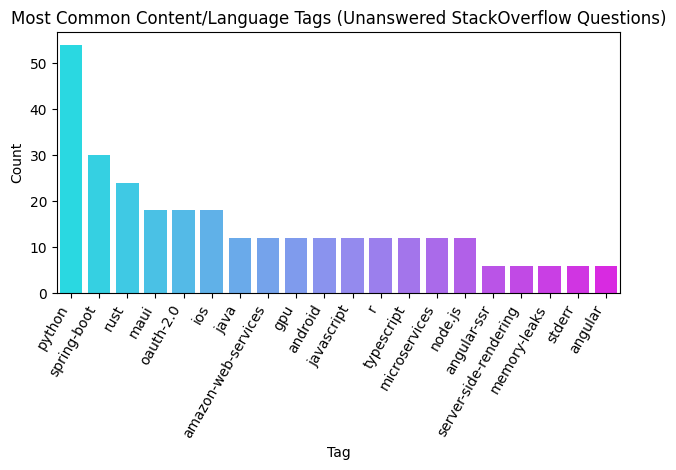

Some of the most common tags include python, spring-boot, rust, maui, oauth-2.0.


In [12]:
x = np.arange(len(tag_counts)) #gather metrics for tag_counts (length spacing of x labels & commanility of each tag [values])
y = tag_counts.values


sns.barplot( #styling + gradient
    x=tag_counts.index,
    y=tag_counts.values,
    palette=sns.color_palette("cool", len(tag_counts))
)

plt.xticks(rotation=60, ha="right")
plt.title("Most Common Content/Language Tags (Unanswered StackOverflow Questions)")
plt.xlabel("Tag")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

top5 = tag_counts.index[:5] #get 5 most common
print(f"Some of the most common tags include {', '.join(top5)}.")


### Verdict Q1: The Top 5 Laungauge Tags by count are Python, Spring-boot, rust, maui and Oauth2.0,

### Answering Question II: Which tags get the most views despite being unanswered?

#### Used CLI/Direct Verdict


In [13]:
tag_views = defaultdict(int)

for _, row in df.iterrows():
    for t in row["ParsedTags"]:
        tag_views[t] += row["Views"]

temp = [(views, tag) for tag, views in tag_views.items()]
temp.sort(reverse=True)
sorted_tags = [(tag, views) for views, tag in temp[:20]]

print(sorted_tags)


[('python', 4668), ('ios', 3438), ('maui', 2472), ('rust', 1872), ('spring-boot', 1734), ('web-scraping', 1266), ('selenium', 1266), ('beautifulsoup', 1266), ('web-applications', 1224), ('service-accounts', 1224), ('http-status-code-401', 1224), ('google-workspace-add-ons', 1224), ('google-apps-script', 1224), ('vb6-migration', 1002), ('vb6', 1002), ('com', 1002), ('c#', 1002), ('activex', 1002), ('xcode', 996), ('react-native', 996)]


### Verdict Q2: Python, IoS, Maui, rust, spring-boot and web-scraping are among the tags that get most views but still have no answer

### Answering Question III: What are the most common words being used in unanswered stackoverflow question (using only whats avaible the question preview)

#### Used Bar-Chart to indicate difference in quantity


In [14]:
text = " ".join(df["Preview Content"].astype(str)).lower() #formats to single str

for ch in string.punctuation: #remove punctuation
    text = text.replace(ch, " ")
for ch in "”“’‘–—…":
    text = text.replace(ch, " ")

words = text.split()

stopwords = set("""
the and or to is a of in for with on that it as this be im my by how what code help not you does using use into from at has have when were been any out can get got your
""".split()) #define common filler words to omit

filtered = [w for w in words if w not in stopwords and len(w) > 2]
#remove irrelevant words (stopwords and words shorter than 3 chars)
counts = Counter(filtered).most_common(20) #counts top 20 in filtered stored in tuple list


/tmp/ipython-input-568612408.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(  #seaborn barplot with gradient rocket


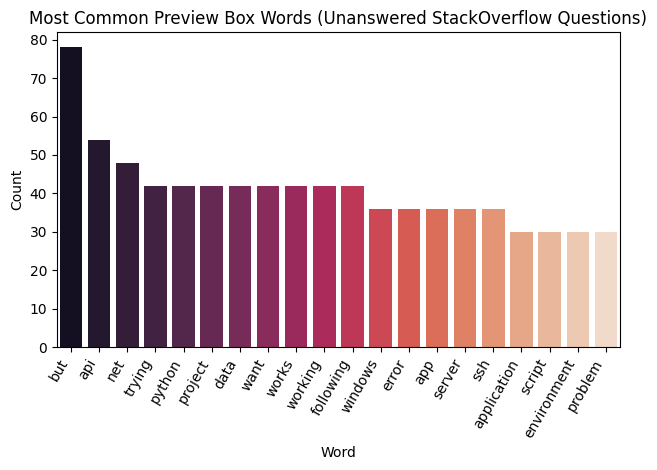

Common Words are: ('but', 78), ('api', 54),('net', 48),(('trying', 42), ('python', 42))


In [15]:
data = pd.DataFrame(counts, columns=["Word", "Count"]) #reformates word tuples with count val pairing

sns.barplot(  #seaborn barplot with gradient rocket
    data=data,
    x="Word",
    y="Count",
    palette="rocket"
)

plt.xticks(rotation=60, ha='right') #styling
plt.title("Most Common Preview Box Words (Unanswered StackOverflow Questions)")
plt.xlabel("Word")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Common Words are: {counts[0]}, {counts[1]},{counts[2]},{counts[3],counts[4]}")

### Verdict Q3: 'But', 'API', 'net, 'trying' and 'python' are the most commonly used words in unanswered questions.

### Answering Question V: What is the average reputation score of users who post unanswered questions?

#### Answer in Label and created barh chart for deeper insight on metadata of data-providers (users)


In [16]:
def bracketer(r): #grouping function for rep bracket
    if r <= 50:
      return "0–50"
    if r <= 200:
      return "51–200"
    if r <= 1000:
      return "201–1000"
    if r <= 5000:
      return "1001–5000"
    if r <= 20000:
      return "5001–20000"
    return "20000+"

df["RepBracket"] = df["User Rep"].apply(bracketer) #apply to rep col
avg_rep = df["User Rep"].mean() #average user rep
counts = df["RepBracket"].value_counts() #gets counts of number of people per bracket

/tmp/ipython-input-3522287310.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


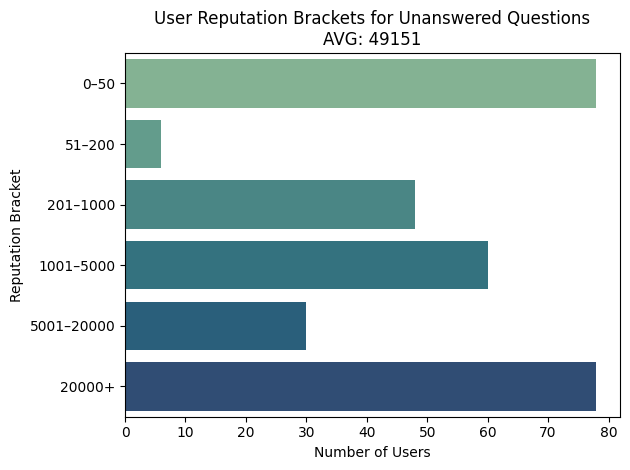

Average Rep Score is: 49151


In [17]:
order = ["0–50", "51–200", "201–1000", "1001–5000", "5001–20000", "20000+"] #setting bracket y-labels

data = pd.DataFrame({ #build mapped df of counts and bracket
    "Bracket": counts.index,
    "Count": counts.values
})

sns.barplot(
    data=data, #seaborn horizontal barplot
    x="Count",
    y="Bracket",
    order=order,
    palette="crest"
)

plt.title(f"User Reputation Brackets for Unanswered Questions\nAVG: {avg_rep:.0f}") #styling
plt.xlabel("Number of Users")
plt.ylabel("Reputation Bracket")
plt.tight_layout()
plt.show()

print(f"Average Rep Score is: {+avg_rep:.0f}")


### Verdict Q5: 49151 is the average stackoverflow Rep score among unanswered questions